# Interpreting results
## Lecture objectives

1. Explore how to interpret a random forests model
2. Show how to report feature importances
3. Explore the use of partial dependence plots

We'll continue with our same example of ADUs in Los Angeles.

First, we'll recreate the same random forests model as before.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# create the dataframe, including dummies
joinedDf = pd.read_pickle('../scratch/joined_permits.pandas')
dummies1 = pd.get_dummies(joinedDf.UseType, prefix='usetype_')  # creates a dataframe of dummies
dummies2 = pd.get_dummies(joinedDf.UseDescription, prefix='usedesc_')
joinedDf = joinedDf.join(dummies1).join(dummies2) 
xvars = (dummies1.columns.tolist() + dummies2.columns.tolist() + 
            ['YearBuilt1', 'Units1', 'Bedrooms1', 'Bathrooms1', 'SQFTmain1', 'Roll_LandValue', 
             'Roll_ImpValue', 'Roll_LandBaseYear', 'Roll_ImpBaseYear', 'CENTER_LAT', 'CENTER_LON' ])
yvar = 'hasADU'
df_to_fit = joinedDf[xvars+[yvar]].dropna()

# test-train split
X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

# estimate and fit the model
rf = RandomForestClassifier(n_estimators = 100, random_state = 1, n_jobs=-1) # n_jobs uses all your computer's cores
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

### Feature importances
In a regression model, the size of the coefficient is a good guide to how important a factor is in determining the outcome.

In a random forests setting, the equivalent concept is *feature importance*. It is often measured through "mean decrease in impurity" (MDI). The meaning of MDI is beyond our scope here, but you can interpret feature importance as "how much does a variable improve our predictions." 

The importances are accessed from the `feature_importances_` property of the `rf` object. [The `scikit-learn` docs provide easy-to-implement examples](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html), which we'll follow here.


Text(0, 0.5, 'Mean decrease in impurity')

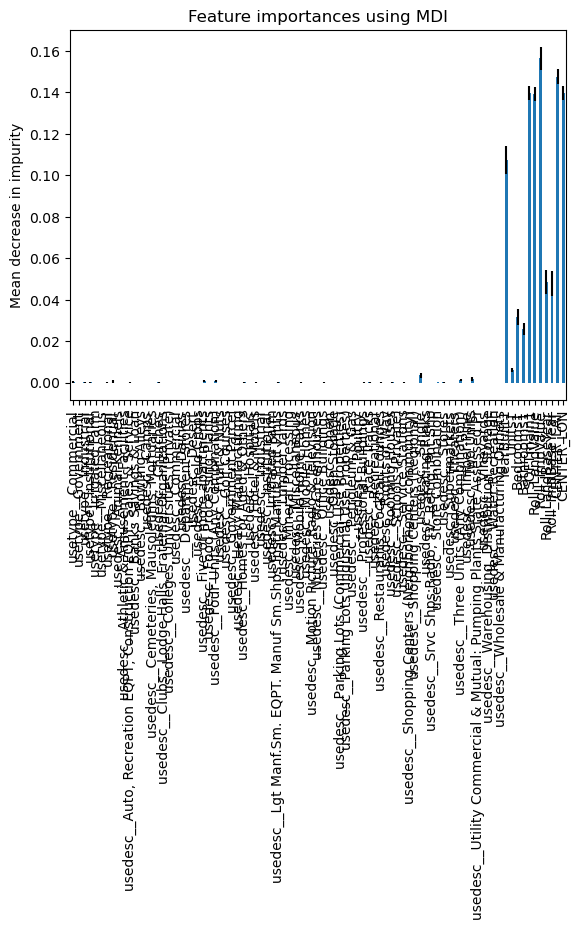

In [2]:
# code from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

import numpy as np
import matplotlib.pyplot as plt
importances = rf.feature_importances_

# convert to a series, and give the index labels from our X_train dataframe
forest_importances = pd.Series(importances, index=X_train.columns)

# get the standard deviations to be able to plot the error bars
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# plot importances
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

So we see that only a few variables are driving the results.

The bar chart is pretty bad. We have a few options:
* Make a larger plot with horizontal bars, so that the text is easier to read
* Only plot the most important features
* Use an interactive tool where you can hover over the bar. The `plotly` and `mplcursors` libraries are two options here.

Let's try the first option.

Text(0, 0.5, 'Mean decrease in impurity')

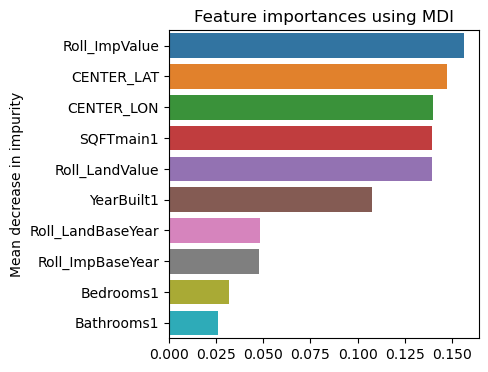

In [7]:
# use seaborn rather than matplotlib
import seaborn as sns

# sort the importances in descending order
forest_importances.sort_values(inplace=True, ascending=False)
top_features = forest_importances[:10]

fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(x=top_features.values, y=top_features.index, ax=ax)
# sns.barplot(x=top_features.values[:10], y=top_features.index[:10], ax=ax)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

We can see that the value of the land and the improvements on the lot, the location (latitude and longitude), size, and year built are the most predictive factors. 


<div class="alert alert-block alert-info">
    <strong>Exercise:</strong> Redo this plot with only the 10 most important features.
</div>

## Partial dependence plots
The feature importances are very useful in highlighting the variables that have a large impact on the predictions.

However, there's one key limitation: they don't tell us the direction of the impact. Does a larger lot make an ADU more or less likely to be built?

There are several ways to examine directionality. One approach is called "SHAP plots" - [here's a detailed explanation.](https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454) I find the beeswarm plots to be most useful, as in my [paper with Nazanin Rezaei](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0278265) where we look at the relationship between urban form, PM2.5 emissions, and access to green space.

Here, we'll look at a simpler way to examine directionality - **partial dependence plots**. In effect, these show the impact of one variable on your outcome, holding all other variables constant. The [scipy documentation is here](https://scikit-learn.org/stable/modules/partial_dependence.html). 

The `PartialDependenceDisplay` is the relevant function. You need to specify the `features` argument - i.e., which variables are going to be plotted. This takes an integer (the order of your features), a variable name, or a list.

For example, suppose we want to plot the impact of `YearBuilt1`. (Note that this can be slow.)

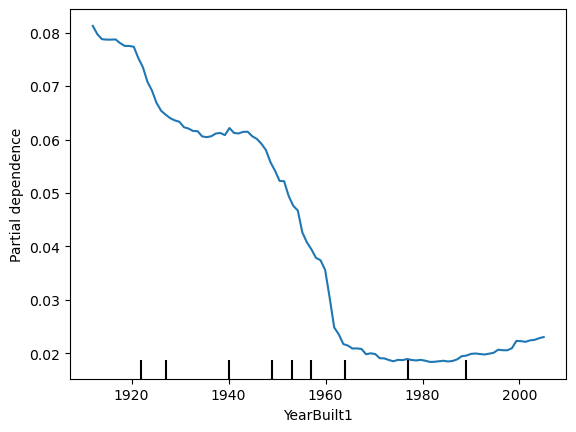

In [8]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(rf, X_test,
                                       ['YearBuilt1'])

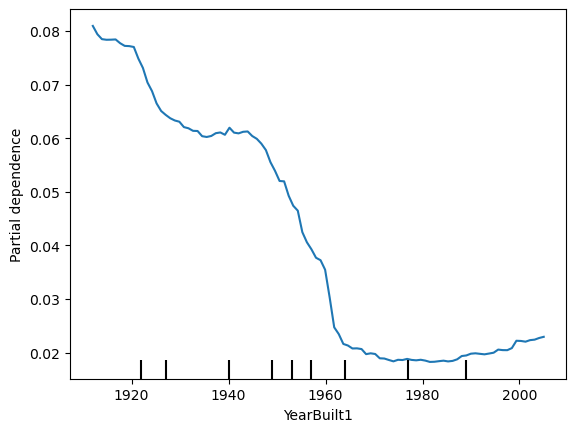

In [9]:
PartialDependenceDisplay.from_estimator(rf, X_train,
                                       ['YearBuilt1'])

Or let's look at the top 3 features, per our feature importances analysis above.

Remember, we already stored these in `forest_importances`, and sorted them by importance.

In [10]:
forest_importances

Roll_ImpValue            0.156492
CENTER_LAT               0.147548
CENTER_LON               0.139819
SQFTmain1                0.139705
Roll_LandValue           0.139327
                           ...   
usedesc__Vineyards       0.000000
usedesc__Camps           0.000000
usedesc__Timber-Pine     0.000000
usedesc__Dairies         0.000000
usedesc__Fruit & Nuts    0.000000
Length: 87, dtype: float64

So we can get the top 3 from the index of `forest_importances`.

In [11]:
forest_importances.index[:3]

Index(['Roll_ImpValue', 'CENTER_LAT', 'CENTER_LON'], dtype='object')

And pass them to `PartialDependenceDisplay`.

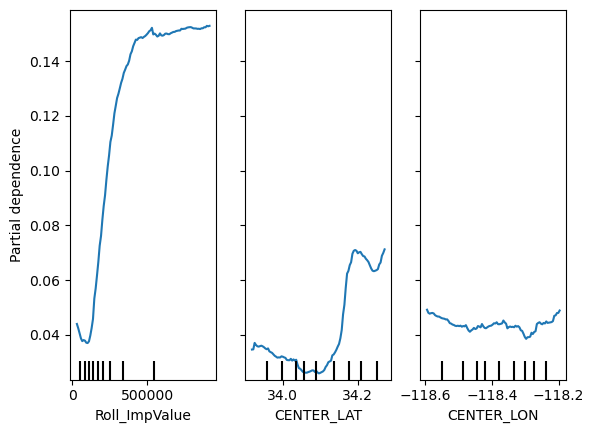

In [12]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(rf, X_test,
                                       forest_importances.index[:3])

In [ ]:
# Using "test" and "train" will give us the same outcome?

<div class="alert alert-block alert-info">
<h3>Key Takeaways</h3>
<ul>
  <li>Feature importance is a way of showing which variables matter in your model.</li>
  <li>However, they don't tell you the directionality - does an increase in one variable increase or reduce the outcome probability. For that, a partial dependence plot is useful.</li>
</ul>
</div>